# Data Exploratory Analysis

---
## Dataset Information

- This Dataset is from Kaggle: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
- This archive contains **2,075,259 measurements** collected between December 2006 and November 2010, covering a span of **47 months**.

### Notes:
1. The expression `global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3` represents the **minute-by-minute active energy consumption** (in watt-hours) of household electrical equipment that is not measured by sub-meterings 1, 2, and 3.
   
2. The dataset contains **missing values**, accounting for approximately **1.25%** of the rows. While all calendar timestamps are present, some measurement values are missing. Missing values are indicated by the absence of any entry between consecutive semicolon delimiters. For example, the dataset shows missing values on **April 28, 2007**.

### Attribute Information:
1. **date**: Date in the format `dd/mm/yyyy`
2. **time**: Time in the format `hh:mm:ss`
3. **global_active_power**: Household global minute-averaged active power (in kilowatts)
4. **global_reactive_power**: Household global minute-averaged reactive power (in kilowatts)
5. **voltage**: Minute-averaged voltage (in volts)
6. **global_intensity**: Household global minute-averaged current intensity (in amperes)
7. **sub_metering_1**: Energy sub-metering No. 1 (in watt-hours), which covers the kitchen, including a dishwasher, oven, and microwave (note: hot plates are gas-powered, not electric).
8. **sub_metering_2**: Energy sub-metering No. 2 (in watt-hours), which corresponds to the laundry room, containing a washing machine, tumble dryer, refrigerator, and lighting.
9. **sub_metering_3**: Energy sub-metering No. 3 (in watt-hours), which corresponds to an electric water heater and air conditioner.

### Table of Contents

1. [Time Series Data Preparation and Cleaning](#1.-Time-Series-Data-Preparation-and-Cleaning)
   - [1.1. Read and construct the Dataset](#1.1.-Read-and-construct-the-Dataset)
   - [1.2. Check and Identify for Null Values](#1.2.-Check-and-Identify-for-Null-Values)
   - [1.3. Fill Null in Data](#1.3.-Fill-Null-in-Data)
   - [1.4. Resample Data by Hour and Day](#1.4.-Resample-Data-by-Hour-and-Day)
2. [Time Series Analysis of 'Global_active_power'](#2.-Time-Series-Analysis-of-'Global_active_power')
   - [2.1. Resampling the Data](#2.1.-Resampling-the-Data)
   - [2.2. Testing for Stationarity (Augmented Dickey-Fuller Test)](#2.2.-Testing-for-Stationarity-(Augmented-Dickey-Fuller-Test))
   - [2.3. Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots](#2.3.-Autocorrelation-(ACF)-and-Partial-Autocorrelation-(PACF)-Plots)
   - [2.4. Rolling Mean and Rolling Standard Deviation](#2.4.-Rolling-Mean-and-Rolling-Standard-Deviation)


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Time Series Data Preparation and Cleaning
This demonstrates the process of preparing and cleaning time series data 
for analysis and forecasting, particularly focusing on handling missing values in 
the 'Global_active_power' column of the household power consumption dataset.

### 1.1. Read and construct the Dataset

In [18]:
# The dataset is read from a text file without parsing the dates initially. 
df = pd.read_csv('data/household_power_consumption.txt', delimiter=';', na_values='?')

# The 'Date' and 'Time' columns are combined into a single 'datetime' column. 
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# The now redundant 'Date' and 'Time' columns are dropped from the DataFrame to streamline 
df = df.drop(columns=['Date', 'Time'])

# The 'datetime' column is set as the index of the DataFrame. This facilitates 
df = df.set_index('datetime')

# The DataFrame is filtered to keep only the 'Global_active_power' column for univariate forecasting
df = df[['Global_active_power']]

### 1.2. Check and Identify for Null Values

In [19]:
# The number of null values in each column is calculated and displayed. 
null_values = df.isnull().sum()
print(null_values)

# Rows containing any null values are filtered and displayed. This helps in identifying the data points that need attention during cleaning.
rows_with_nulls = df[df.isnull().any(axis=1)]
rows_with_nulls

Global_active_power    25979
dtype: int64


,Global_active_power
datetime,
2006-12-21 11:23:00,NaN
2006-12-21 11:24:00,NaN
2006-12-30 10:08:00,NaN
2006-12-30 10:09:00,NaN
2007-01-14 18:36:00,NaN
...,...
2010-09-28 19:09:00,NaN
2010-09-28 19:10:00,NaN
2010-09-28 19:11:00,NaN


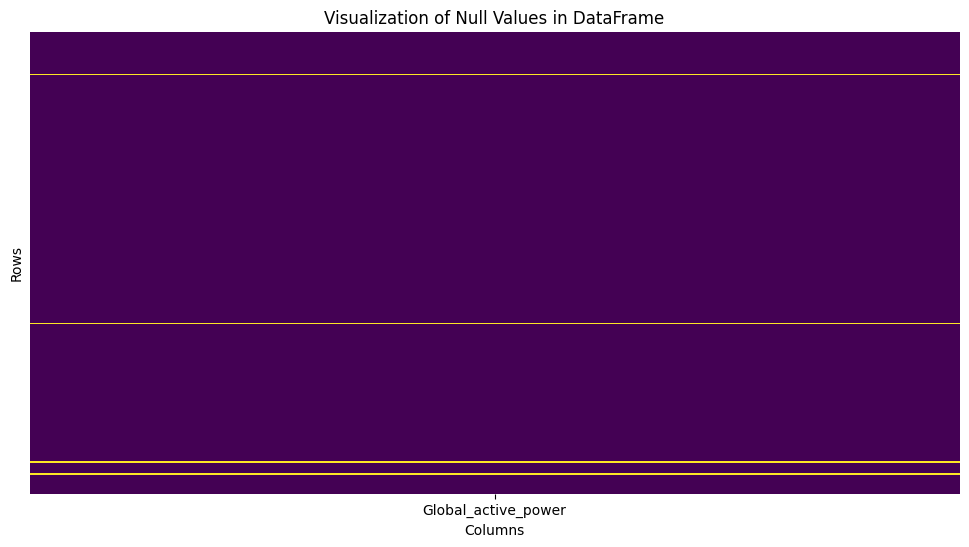

In [20]:
# A heatmap is created to visualize the null values in the DataFrame. 
# This provides a clearer picture of where the data is missing.
null_mask = df.isnull()
plt.figure(figsize=(12, 6))
sns.heatmap(null_mask, cbar=False, cmap='viridis', yticklabels=False)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Visualization of Null Values in DataFrame')
plt.show()

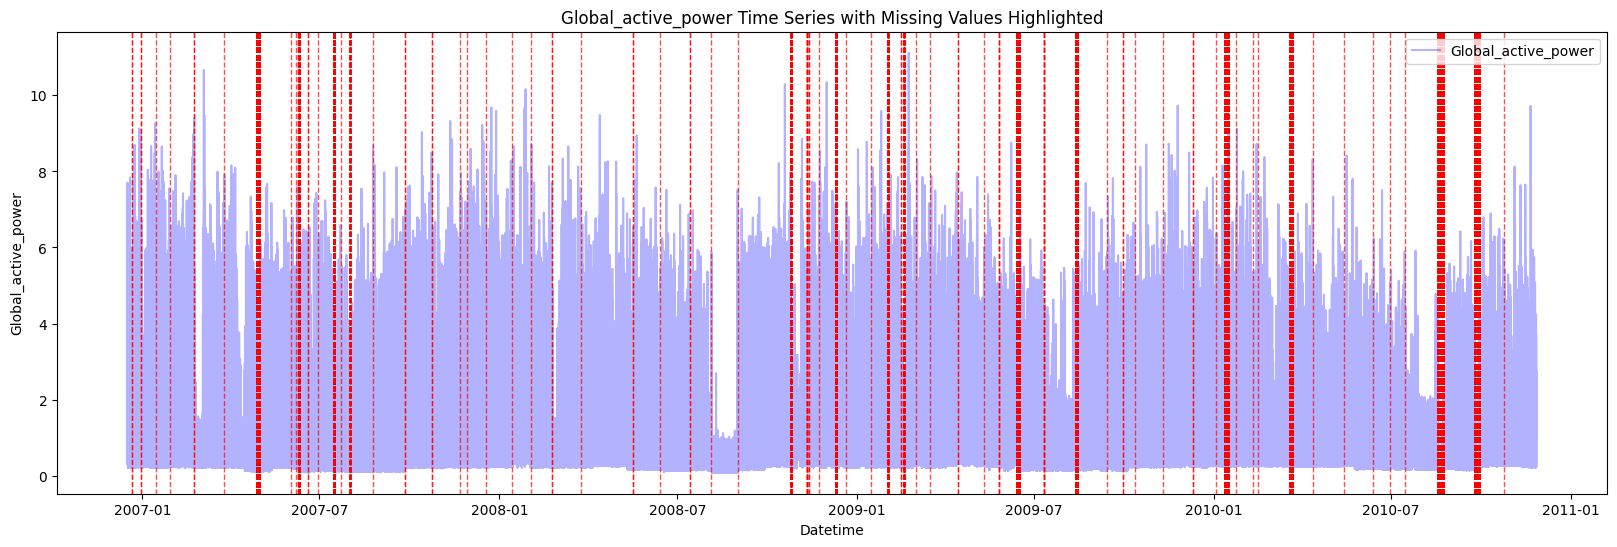

In [21]:
# The 'Global_active_power' data is plotted, with vertical lines drawn at each missing value. 
# This helps to visualize the impact of missing data on the time series.
null_mask = df['Global_active_power'].isnull()
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Global_active_power'], label='Global_active_power', color='blue', alpha=0.3)
for null_time in df.index[null_mask]:
    plt.axvline(x=null_time, color='red', linestyle='--', lw=1, alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('Global_active_power')
plt.title('Global_active_power Time Series with Missing Values Highlighted')
plt.legend(loc='upper right')
plt.show()

In [22]:
# Identifies and lists the ranges of consecutive null values found in the dataset, which is important for determining how to fill those gaps effectively.
null_mask = df.isnull().any(axis=1)
null_ranges = []
current_start = None

# Iterate over the range of the null mask to identify consecutive null values
for i in range(len(null_mask)):
    # Check if the current index has a null value
    if null_mask.iloc[i]:
        # If this is the start of a new range of nulls, mark the starting index
        if current_start is None:
            current_start = i 
    else:
        # If we encounter a non-null value and there was a previous null range
        if current_start is not None:
            current_end = i - 1  # End of the current range of nulls
            current_length = current_end - current_start + 1  # Calculate the length of the null range
            null_ranges.append((current_start, current_end, current_length)) 
            current_start = None  # Reset current_start to None, indicating the end of the null range

# Check if there is an open range of null values at the end of the DataFrame
if current_start is not None:
    current_end = len(null_mask) - 1  # Set the end index to the last index of the null mask
    current_length = current_end - current_start + 1  # Calculate the length of this range
    null_ranges.append((current_start, current_end, current_length)) 

# Sort and report the largest ranges of consecutive nulls
null_ranges.sort(key=lambda x: x[2], reverse=True)
top_20_ranges = null_ranges[:20]

if top_20_ranges:
    print("Top 20 largest ranges of consecutive nulls:")
    for idx, (start, end, length) in enumerate(top_20_ranges, 1):
        print(f"{idx}. {length} rows from index {start} to {end}.")
else:
    print("No consecutive null values found.")

Top 20 largest ranges of consecutive nulls:
1. 7226 rows from index 1929818 to 1937043.
2. 5237 rows from index 1984952 to 1990188.
3. 3723 rows from index 190497 to 194219.
4. 3305 rows from index 1309386 to 1312690.
5. 3129 rows from index 1616969 to 1620097.
6. 2027 rows from index 1712788 to 1714814.
7. 891 rows from index 1397496 to 1398386.
8. 83 rows from index 303805 to 303887.
9. 70 rows from index 1043604 to 1043673.
10. 47 rows from index 303897 to 303943.
11. 43 rows from index 977344 to 977386.
12. 38 rows from index 1120265 to 1120302.
13. 33 rows from index 252035 to 252067.
14. 24 rows from index 1142922 to 1142945.
15. 21 rows from index 327768 to 327788.
16. 6 rows from index 1000819 to 1000824.
17. 4 rows from index 1349584 to 1349587.
18. 3 rows from index 252031 to 252033.
19. 3 rows from index 1283719 to 1283721.
20. 2 rows from index 6839 to 6840.


### 1.3. Fill Null in Data

Given the top 20 largest ranges of nulls, a combined strategy might be the most effective approach. Here’s a strategy:
- For small gaps (less than ~100 rows): Use interpolation. These gaps can be reasonably filled by linear interpolation, as small gaps are unlikely to change trends significantly.
- For medium gaps (100-1000 rows): Consider moving average or linear interpolation but validate with visualization. For gaps between 83 to 891 rows, interpolation or moving averages can smooth over the missing values while preserving trends.
- For large gaps (1000+ rows): Use mean/median fill for large ranges (like the 7226 or 5237-row gaps) or custom fill using domain knowledge (e.g., using a mean/median of values before and after the gap). Large gaps are difficult to fill accurately with interpolation, so filling them with a constant value can help prevent interpolation artifacts.


In [25]:
# A custom function is defined to classify the gaps based on size and fill them accordingly.
def fill_gaps(df, column_name, ranges, large_gap_limit=1000, medium_gap_limit=100):
    """
    Fills gaps (missing values) in a specified column of a DataFrame based on the size of consecutive null ranges.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the column with missing values that need to be filled.
    column_name : str
        The name of the column in the DataFrame where gaps will be filled.
    ranges : list of tuples
        A list of tuples where each tuple contains the start index, end index, and size (length) of consecutive null ranges.
    large_gap_limit : int, optional, default=1000
        The threshold for treating a gap as large. Gaps larger than this limit will be filled with the mean value.
        
    medium_gap_limit : int, optional, default=100
        The threshold for treating a gap as medium. Gaps between the medium and large limit will be filled using the moving average.
    
    Returns:
    --------
    pandas.DataFrame
        The modified DataFrame with filled gaps in the specified column.
    
    Notes:
    ------
    - For small gaps (less than `medium_gap_limit`), linear interpolation is used.
    - For medium-sized gaps (between `medium_gap_limit` and `large_gap_limit`), moving average is used.
    - For large gaps (greater than `large_gap_limit`), the column's mean value is used to fill the gaps.
    """
    
    # Iterate over each range of null values in the list
    for start, end, size in ranges:
        if size < medium_gap_limit:
            # Small gap: use linear interpolation to fill
            df.loc[df.index[start:end], column_name] = df.loc[df.index[start:end], column_name].interpolate(method='linear')
        elif medium_gap_limit <= size < large_gap_limit:
            # Medium gap: fill using a rolling mean
            rolling_mean = df[column_name].rolling(window=50, min_periods=1).mean()
            df.loc[df.index[start:end], column_name] = rolling_mean.loc[df.index[start:end]]
        else:
            # Large gap: fill using the mean value of the column
            mean_value = df[column_name].mean()
            df.loc[df.index[start:end], column_name] = mean_value

    return df

In [26]:
# The fill_gaps function is applied to the 'Global_active_power' column.
df = fill_gaps(df, 'Global_active_power', null_ranges)

# A check is performed for any remaining null values after applying the filling strategy. 
remaining_nulls = df['Global_active_power'].isna().sum()
print(f'Remaining null values after filling gaps: {remaining_nulls}')

if remaining_nulls > 0:
    df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())
    df['Global_active_power'] = df['Global_active_power'].ffill()
    df['Global_active_power'] = df['Global_active_power'].bfill()
    remaining_nulls = df['Global_active_power'].isna().sum()
    print(f'Remaining null values after all filling methods: {remaining_nulls}')

# A final check is performed to ensure that all gaps in the data have been filled, with the expectation that no null values should remain.
print(df['Global_active_power'].isna().sum())  # Should return 0 if all gaps are filled

Remaining null values after filling gaps: 1289
Remaining null values after all filling methods: 0
0


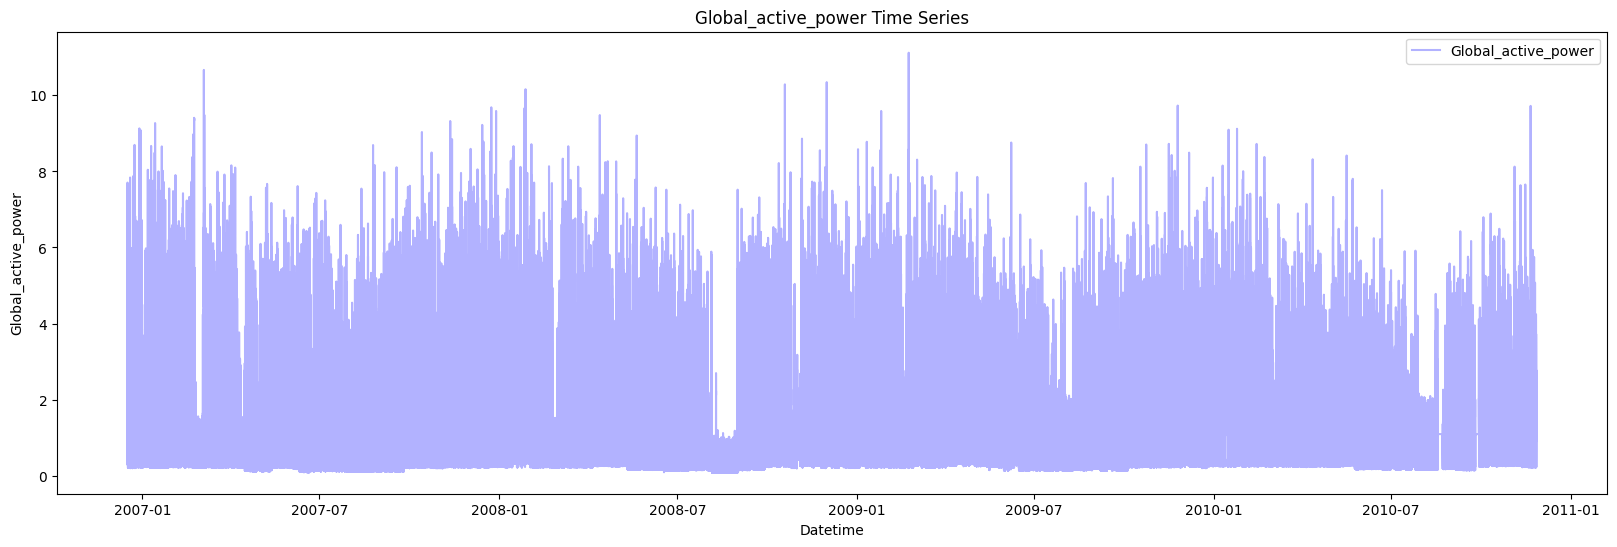

In [27]:
# Visualize Cleaned Data
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Global_active_power'], label='Global_active_power', color='blue', alpha=0.3)
plt.xlabel('Datetime')
plt.ylabel('Global_active_power')
plt.title('Global_active_power Time Series')
plt.legend(loc='upper right')
plt.show()

### 1.4. Resample Data by Hour and Day

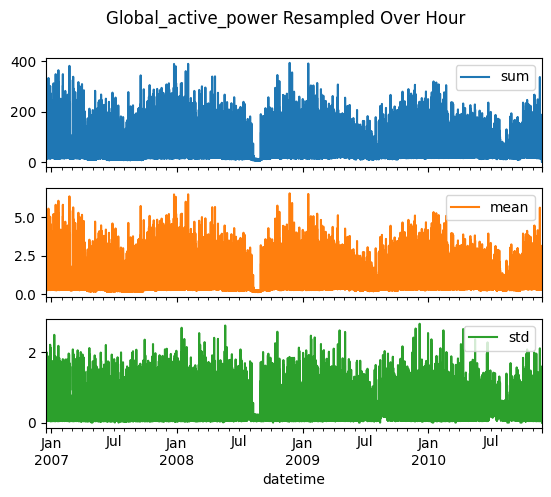

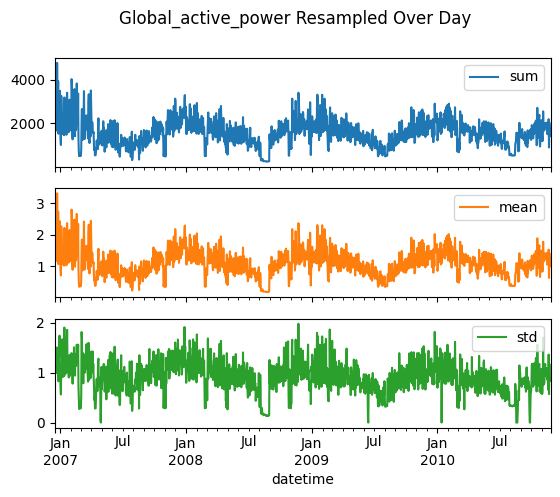

In [32]:
# The data is resampled to calculate the sum, mean, and standard deviation of 'Global_active_power' over each hour for further analysis.
df_hour = df.Global_active_power.resample('h').agg(['sum','mean', 'std'])
df_hour.plot(subplots=True, title='Global_active_power Resampled Over Hour')
plt.show()

df_day = df.Global_active_power.resample('D').agg(['sum','mean', 'std'])
df_day.plot(subplots=True, title='Global_active_power Resampled Over Day')
plt.show()

## 2. Time Series Analysis of 'Global_active_power'

This demonstrates a comprehensive time series analysis of the 'Global_active_power' column from a DataFrame. The analysis includes resampling, seasonal decomposition, stationarity tests, autocorrelation and partial autocorrelation function plots, and rolling statistics.

### 2.1. Resampling the Data

Seasonal decomposition is applied to break down the time series into three components:

- Trend: The overall direction of the data (upward or downward movement).
- Seasonality: Repeating patterns over time (e.g., daily, weekly patterns).
- Residuals: The noise or randomness after removing trend and seasonality.

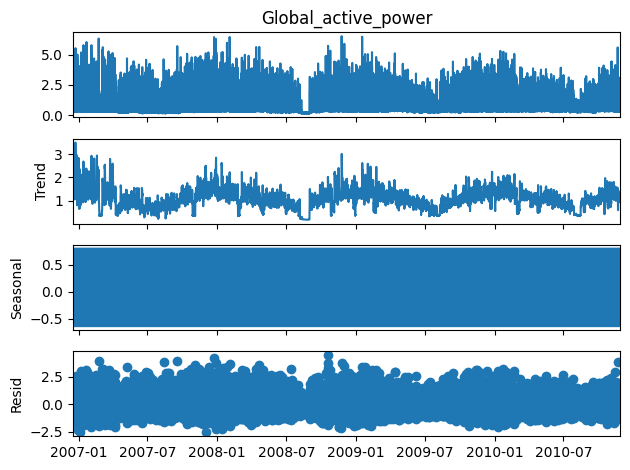

In [28]:
# resample the data per hour
temp = df['Global_active_power'].resample('h').mean().reset_index()
temp.columns = ['Date', 'Global_active_power']
temp = temp.set_index('Date')

# Seasonal decomposition
result = seasonal_decompose(temp['Global_active_power'], model='additive')
result.plot()
plt.show()

# Interpretation:
# 1. Trend: Look for the long-term movement in the data. A clear upward or downward slope indicates a trend.
# 2. Seasonality: Observe any repeating patterns over a fixed period (e.g., daily, weekly).
# 3. Residuals: Check the randomness of residuals; non-randomness may indicate an underlying pattern.

### 2.2. Testing for Stationarity (Augmented Dickey-Fuller Test)

Stationarity is crucial in time series modeling. The Augmented Dickey-Fuller (ADF) test checks if a time series is stationary or if it needs differencing or transformation.

In [29]:
# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(temp['Global_active_power'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Interpretation:
# - If the p-value < 0.05, you can reject the null hypothesis of a unit root, indicating the time series is stationary.
# - If the p-value > 0.05, the series may be non-stationary, which often requires differencing or transformations.

ADF Statistic: -14.367744958802588
p-value: 9.608600573836171e-27


### 2.3. Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots

The ACF and PACF plots help determine if there is significant autocorrelation (relationships with past values) in the data and help in identifying the AR (Auto-Regressive) and MA (Moving Average) components for time series models.

In [ ]:
# ACF and PACF plots
plot_acf(temp['Global_active_power'])
plt.title('ACF Plot')
plt.show()

# Interpretation:
# - The ACF plot shows how correlated the data is with its lagged values. Significant spikes indicate seasonality or autocorrelation.
# - Look for where the ACF plot cuts off or tails off to determine the order of the MA (Moving Average) component.

plot_pacf(temp['Global_active_power'])
plt.title('PACF Plot')
plt.show()

# Interpretation:
# - The PACF plot helps identify the order of the AR (Auto-Regressive) component. Significant spikes indicate lags that are correlated after removing the effects of shorter lags.

### 2.4. Rolling Mean and Rolling Standard Deviation

To understand trends and variability in the time series, rolling statistics (mean and standard deviation) are plotted. This helps identify changes in trends and volatility over time.

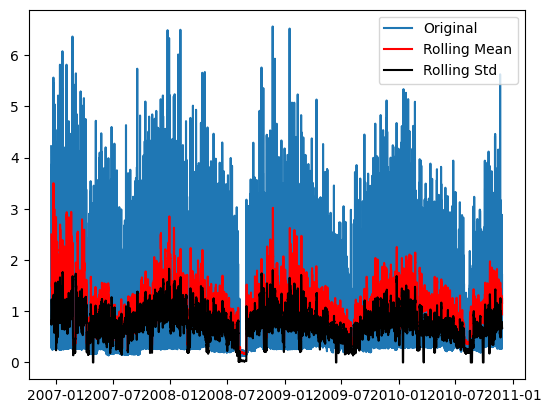

In [31]:
# Rolling mean and standard deviation
rolling_mean = temp['Global_active_power'].rolling(window=24).mean()
rolling_std = temp['Global_active_power'].rolling(window=24).std()

plt.plot(temp['Global_active_power'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()
plt.show()

# Interpretation:
# - The rolling mean and rolling standard deviation help to visualize trends and variability over time.
# - If the rolling mean is increasing or decreasing over time, it suggests the presence of a trend.
# - If the rolling standard deviation shows significant changes, it might indicate varying volatility in the time series.

In [15]:
# Save the Clean dataset as csv
temp = df['Global_active_power'].resample('h').mean().reset_index()
temp.columns = ['Date', 'Global_active_power']
temp = temp.set_index('Date')

# Save the DataFrame as a CSV file
temp.to_csv('global_active_power_hourly.csv', index=True)